In [14]:
import copy
import pickle
import os.path as osp

import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import models, transforms

# from grad_cam import (
#     BackPropagation,
#     Deconvnet,
#     GradCAM,
#     GuidedBackPropagation,
#     occlusion_sensitivity,
# )

In [2]:
def get_device(cuda):
    cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    if cuda:
        current_device = torch.cuda.current_device()
        print("Device:", torch.cuda.get_device_name(current_device))
    else:
        print("Device: CPU")
    return device


def load_images(image_paths):
    images = []
    raw_images = []
    print("Images:")
    for i, image_path in enumerate(image_paths):
        print("\t#{}: {}".format(i, image_path))
        image, raw_image = preprocess(image_path)
        images.append(image)
        raw_images.append(raw_image)
    return images, raw_images


def get_classtable():
    classes = []
    for index in range(1000):
        line = imagenet_class_labels[index]
        line = line.split(", ", 1)[0].replace(" ", "_")
        classes.append(line)
    # with open("./data/synset_words.txt") as lines:
    #     for line in lines:
    #         line = line.strip().split(" ", 1)[1]
    #         line = line.split(", ", 1)[0].replace(" ", "_")
    #         classes.append(line)
    return classes


def preprocess(image_path):
    raw_image = cv2.imread(image_path)
    raw_image = cv2.resize(raw_image, (224,) * 2)
    image = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )(raw_image[..., ::-1].copy())
    return image, raw_image


def save_gradient(filename, gradient):
    gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
    cv2.imwrite(filename, np.uint8(gradient))


def save_gradcam(filename, gcam, raw_image, paper_cmap=False):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * raw_image
    else:
        gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
    cv2.imwrite(filename, np.uint8(gcam))


def save_sensitivity(filename, maps):
    maps = maps.cpu().numpy()
    scale = max(maps[maps > 0].max(), -maps[maps <= 0].min())
    maps = maps / scale * 0.5
    maps += 0.5
    maps = cm.bwr_r(maps)[..., :3]
    maps = np.uint8(maps * 255.0)
    maps = cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(filename, maps)

In [3]:
# torchvision models
model_names = sorted(
    name
    for name in models.__dict__
    if name.islower() and not name.startswith("__") and callable(models.__dict__[name])
)

In [4]:
model = models.resnet18()

In [5]:
type(model)

torchvision.models.resnet.ResNet

In [6]:
type(next(model.modules()))

torchvision.models.resnet.ResNet

In [7]:
with open("./data/imagenet_class_labels.pkl", "rb") as label_file:
    imagenet_class_labels = pickle.load(label_file)

In [6]:
def DifferentVisualDemo(image_paths, target_layer, arch, topk, output_dir, cuda):
    """
    Visualize model responses given multiple images.
    """
    device = get_device(cuda)

    # Synset words
    classes = get_classtable()
    # print(classes)

    # Model from torchvision
    model = models.__dict__[arch](pretrained=True)
    model.to(device)
    model.eval()

    # Images
    images, raw_images = load_images(image_paths)
    images = torch.stack(images).to(device)
    
    """
    Common usage:
    1. Wrap your model with visualization classes defined in grad_cam.py
    2. Run forward() with images
    3. Run backward() with a list of specific classes
    4. Run generate() to export results
    """
    
    # =========================================================================
    print("Vanilla Backpropagation:")

    bp = BackPropagation(model=model)
    probs, ids = bp.forward(images)  # sorted
    
    for i in range(topk):
        bp.backward(ids=ids[:, [i]])
        gradients = bp.generate()

        # Save results as image files
        for j in range(len(images)):
            print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

            save_gradient(
                filename=osp.join(
                    output_dir,
                    "{}-{}-vanilla-{}.png".format(j, arch, classes[ids[j, i]]),
                ),
                gradient=gradients[j],
            )
    
    # Remove all the hook function in the "model"
    bp.remove_hook()
    
    # =========================================================================
    print("Deconvolution:")

    deconv = Deconvnet(model=model)
    _ = deconv.forward(images)

    for i in range(topk):
        deconv.backward(ids=ids[:, [i]])
        gradients = deconv.generate()

        for j in range(len(images)):
            print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

            save_gradient(
                filename=osp.join(
                    output_dir,
                    "{}-{}-deconvnet-{}.png".format(j, arch, classes[ids[j, i]]),
                ),
                gradient=gradients[j],
            )

    deconv.remove_hook()
    
    # =========================================================================
    print("Grad-CAM/Guided Backpropagation/Guided Grad-CAM:")

    gcam = GradCAM(model=model)
    _ = gcam.forward(images)

    gbp = GuidedBackPropagation(model=model)
    _ = gbp.forward(images)

    for i in range(topk):
        # Guided Backpropagation
        gbp.backward(ids=ids[:, [i]])
        gradients = gbp.generate()

        # Grad-CAM
        gcam.backward(ids=ids[:, [i]])
        regions = gcam.generate(target_layer=target_layer)

        for j in range(len(images)):
            print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

            # Guided Backpropagation
            save_gradient(
                filename=osp.join(
                    output_dir,
                    "{}-{}-guided-{}.png".format(j, arch, classes[ids[j, i]]),
                ),
                gradient=gradients[j],
            )

            # Grad-CAM
            save_gradcam(
                filename=osp.join(
                    output_dir,
                    "{}-{}-gradcam-{}-{}.png".format(
                        j, arch, target_layer, classes[ids[j, i]]
                    ),
                ),
                gcam=regions[j, 0],
                raw_image=raw_images[j],
            )

            # Guided Grad-CAM
            save_gradient(
                filename=osp.join(
                    output_dir,
                    "{}-{}-guided_gradcam-{}-{}.png".format(
                        j, arch, target_layer, classes[ids[j, i]]
                    ),
                ),
                gradient=torch.mul(regions, gradients)[j],
            )

In [7]:
DifferentVisualDemo(["./data/images/tiger_shark.jpeg"], "layer4", "resnet18", 1, "./data/outputs/", False)

Device: CPU
Images:
	#0: ./data/images/tiger_shark.jpeg
Vanilla Backpropagation:
	#0: tiger_shark (0.97557)
Deconvolution:


/Users/ashutosh1919/miniforge3/envs/cnn_xai/lib/python3.8/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


	#0: tiger_shark (0.97557)
Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
	#0: tiger_shark (0.97557)


/var/folders/y1/pm6_lt111h92v74z5vt3_vhh0000gn/T/ipykernel_95377/2648377605.py:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2


In [8]:
def LayersDemo(image_paths, target_class, output_dir, cuda):
    device = get_device(cuda)

    # Synset words
    classes = get_classtable()
    # print(classes)

    # Model from torchvision
    model = models.resnet18(pretrained=True)
    model.to(device)
    model.eval()
    
    # The four residual layers
    target_layers = ["relu", "layer1", "layer2", "layer3", "layer4"]

    # Images
    images, raw_images = load_images(image_paths)
    images = torch.stack(images).to(device)
    
    gcam = GradCAM(model=model)
    probs, ids = gcam.forward(images)
    ids_ = torch.LongTensor([[target_class]] * len(images)).to(device)
    gcam.backward(ids=ids_)

    for target_layer in target_layers:
        print("Generating Grad-CAM @{}".format(target_layer))

        # Grad-CAM
        regions = gcam.generate(target_layer=target_layer)

        for j in range(len(images)):
            print(
                "\t#{}: {} ({:.5f})".format(
                    j, classes[target_class], float(probs[ids == target_class])
                )
            )

            save_gradcam(
                filename=osp.join(
                    output_dir,
                    "{}-{}-gradcam-{}-{}.png".format(
                        j, "resnet18", target_layer, classes[target_class]
                    ),
                ),
                gcam=regions[j, 0],
                raw_image=raw_images[j],
            )

In [9]:
LayersDemo(["./data/images/tiger_shark.jpeg"], 3, "./data/outputs", False)

Device: CPU
Images:
	#0: ./data/images/tiger_shark.jpeg
Generating Grad-CAM @relu
	#0: tiger_shark (0.97557)
Generating Grad-CAM @layer1
	#0: tiger_shark (0.97557)
Generating Grad-CAM @layer2
	#0: tiger_shark (0.97557)
Generating Grad-CAM @layer3
	#0: tiger_shark (0.97557)
Generating Grad-CAM @layer4
	#0: tiger_shark (0.97557)


/var/folders/y1/pm6_lt111h92v74z5vt3_vhh0000gn/T/ipykernel_95377/2648377605.py:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2


In [14]:
import torch
from torch import nn
from explain_cnn.validators.base_validator import BaseValidator


class BaseExplainer:
    def __init__(self,
                 model,
                 device="cpu"):
        """
        This class creates base of explainer module which works
        as the fundamental module to work with this package.
        
        Args:
            model: `torch.nn.Module` object containing the PyTorch model
            device: `str` containing the type of device to execute the code
        """
        
        self.validator = BaseValidator()
        self.validator.assert_type(model, nn.Module)
        self.validator.assert_type(device, str)
        
        self.model = model
        self.device = self.get_device(device)
        self.model.to(self.device)
        self.model.eval()
    
    def get_device(self, device):
        """
        Returns `torch.device` Object.
        
        Args:
            device: `str` containing the type of device to execute the code
        
        Returns: `torch.device` object to allocate all tensors related to model
        """
        return torch.device(device)
    
    def get_reverse_class_map(self, class_map):
        """
        Generates reverse class mapping from index to label map.
        
        Args:
            class_map: `dict` containing mapping from class index to label
        
        Returns: reverse class mapping from label to index
        """
        reverse_class_mapping = {}
        for index, label in class_map.items():
            reverse_class_mapping[label] = index
        return reverse_class_mapping

In [15]:
BaseExplainer(models.resnet18(), "cpu")

## Manual Testing

In [8]:
from explainable_cnn.explainers import CNNExplainer

In [9]:
model = models.resnet18(pretrained=True)

In [32]:
x_cnn = CNNExplainer(model, imagenet_class_labels)
layers = ["relu", "layer1", "layer2", "layer3", "layer4"]

In [30]:
models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
cams = x_cnn.get_grad_cam(
    "./data/images/tiger_shark.jpeg",
    3,
    (224, 224),
    layers
)

relu


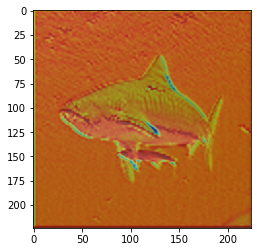

layer1


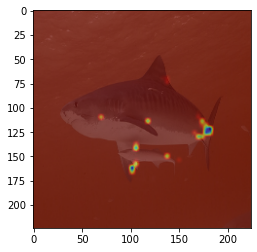

layer2


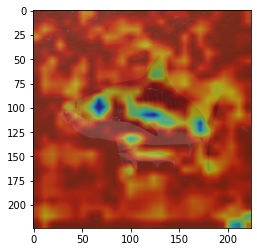

layer3


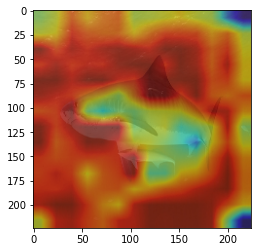

layer4


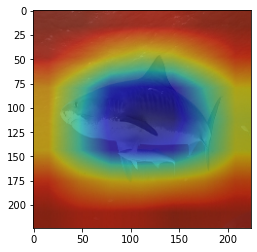

In [41]:
for layer, cam in zip(layers, cams):
    print(layer)
    plt.imshow(cam.astype('uint8'))
    plt.show()